This notebook is for creating the base ML model.

In [1]:
model_name = "eval_metric_wape" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [4]:
df.shape

(7319643, 3)

In [5]:
df.head()

datetime  location  busyness
0 2021-01-01         3       132
1 2021-01-01         4       234
2 2021-01-01         5        19
3 2021-01-01         6        37
4 2021-01-01         7       493

In [6]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01       132
4       2021-01-01       234
5       2021-01-01        19
6       2021-01-01        37
7       2021-01-01       493


In [7]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [8]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="WAPE",
    prediction_length=prediction_length,
    path=model_name
)
print('we made the predictor')

we made the predictor


In [9]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'eval_metric_wape_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       7.12 GB / 15.90 GB (44.8%)
Disk Space Avail:   2136.50 GB / 2794.50 GB (76.5%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WAPE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%), 

In [10]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -0.229056     654.188610         101.170901          7
1     SeasonalNaive  -0.262175       1.027789           4.164828          2
2     DirectTabular  -0.361884      43.918281         174.285704          4
3  RecursiveTabular  -0.397712     554.014406         324.884515          3
4             Theta  -0.434726      51.556745           4.427561          6
5             Naive  -0.475932       3.671389           4.377297          1
6               ETS  -1.310946     205.250605           4.478752          5


In [11]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  154.925242  120.933479  132.527841  140.893769   
        2024-01-02 00:00:00   93.986544   55.586404   68.759884   78.250890   
        2024-01-02 01:00:00  122.535334   80.739440   95.074433  105.389911   
        2024-01-02 02:00:00  110.619770   66.175884   81.419692   92.443213   
        2024-01-02 03:00:00   71.810512   24.698701   40.852492   52.527125   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.173286  -11.898190   -7.411580   -4.172359   
        2022-04-23 14:00:00    1.163951  -11.909449   -7.420404   -4.179497   
        2022-04-23 15:00:00    1.162910  -11.914696   -7.423328   -4.183932   
        2022-04-23 16:00:00    1.159323  -11.921362   -7.426288   -4.186656   
        2022-04-23 17:00:00    1.174987  -11.922676 

data with frequency 'None' has been resampled to frequency 'h'.


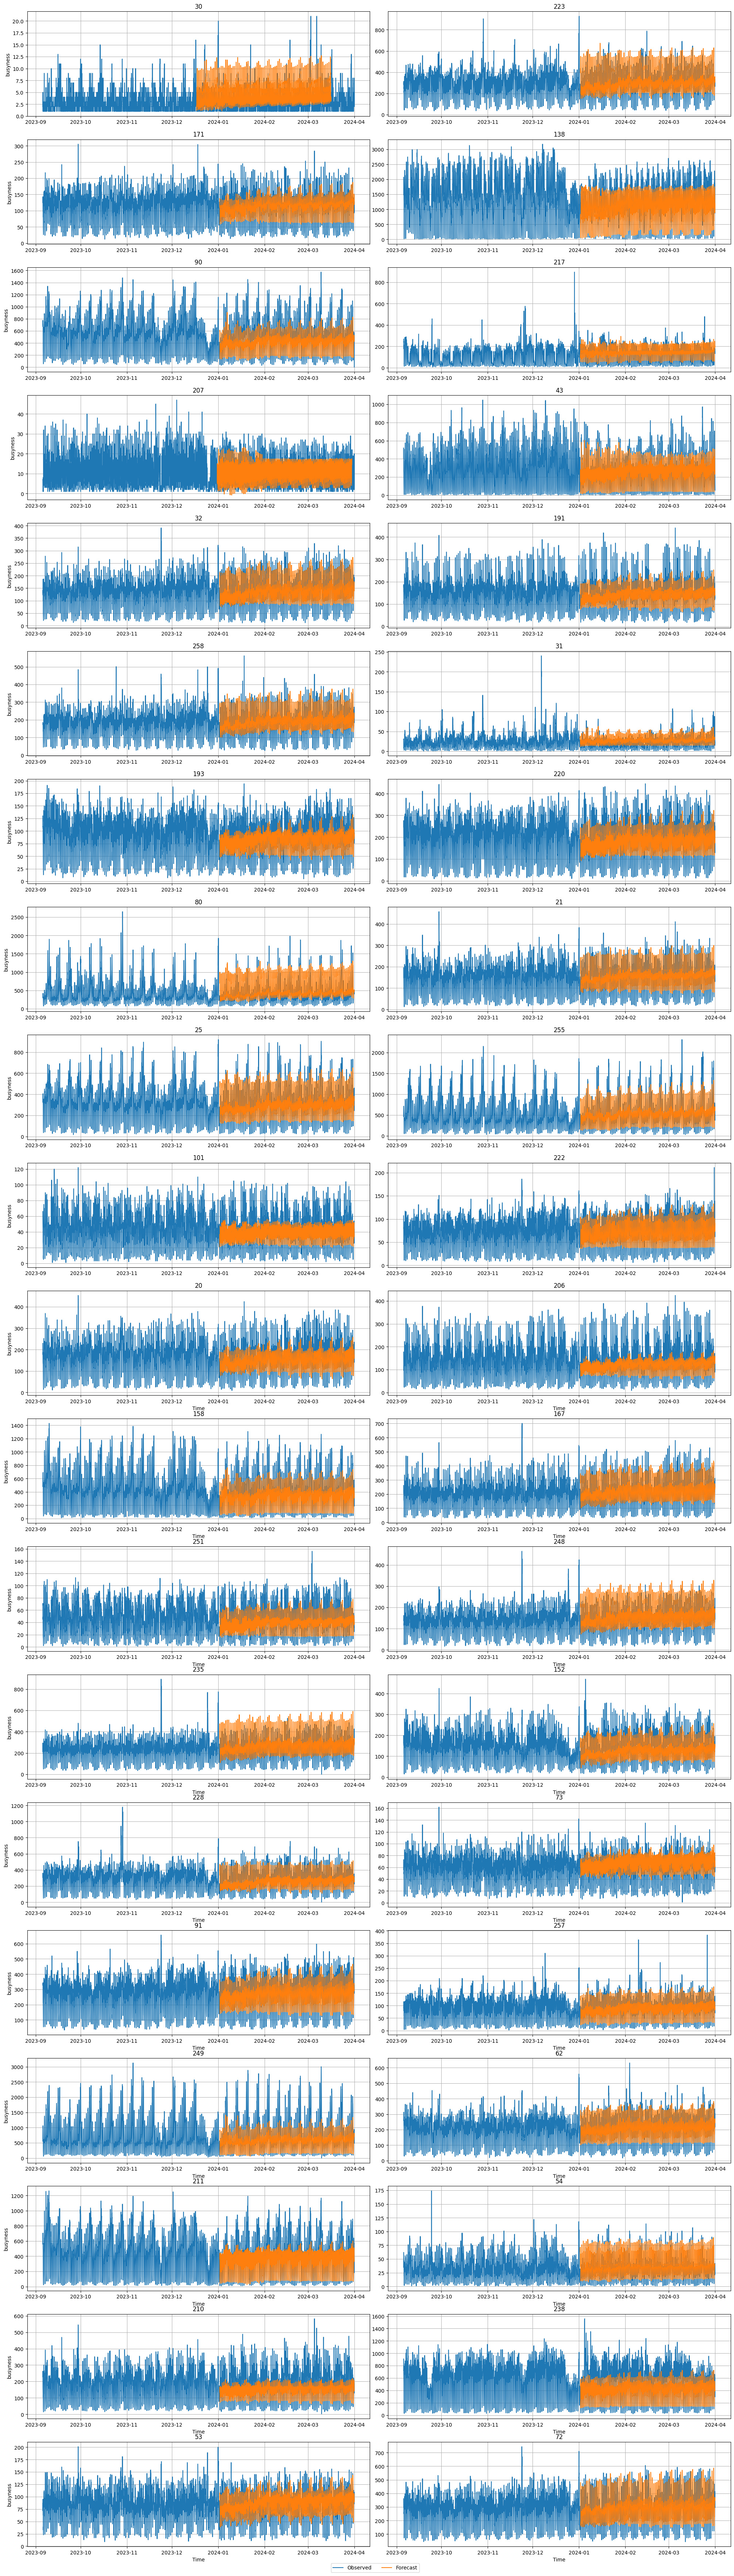

In [12]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=40)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


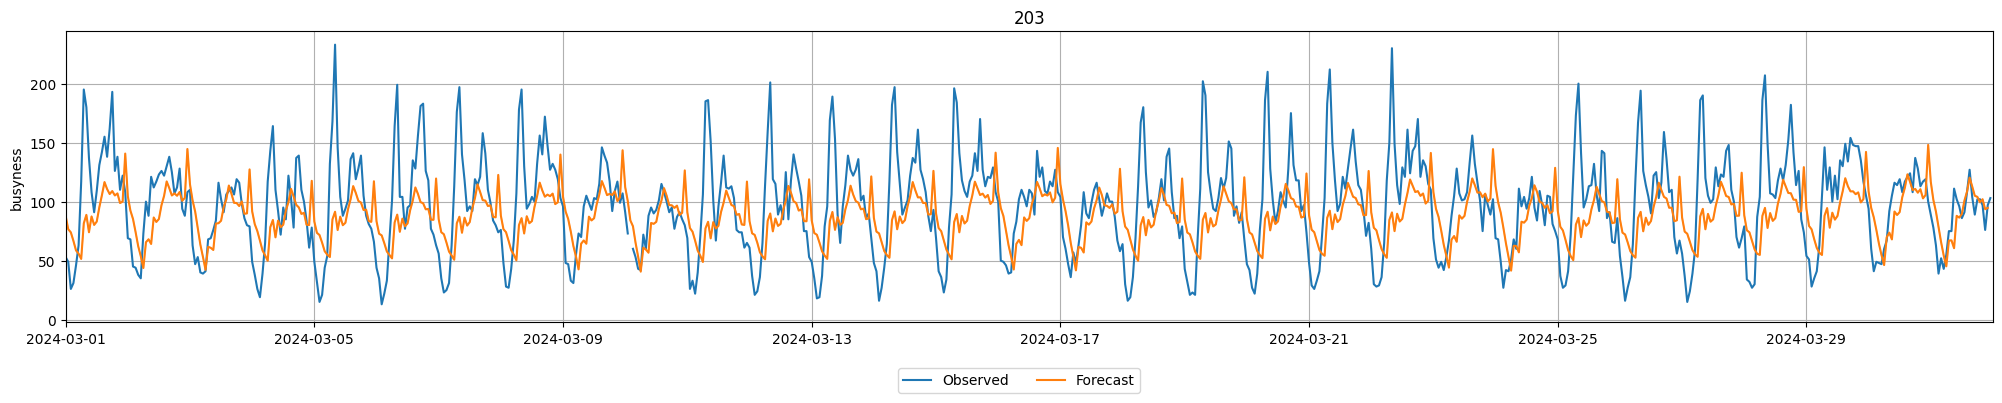

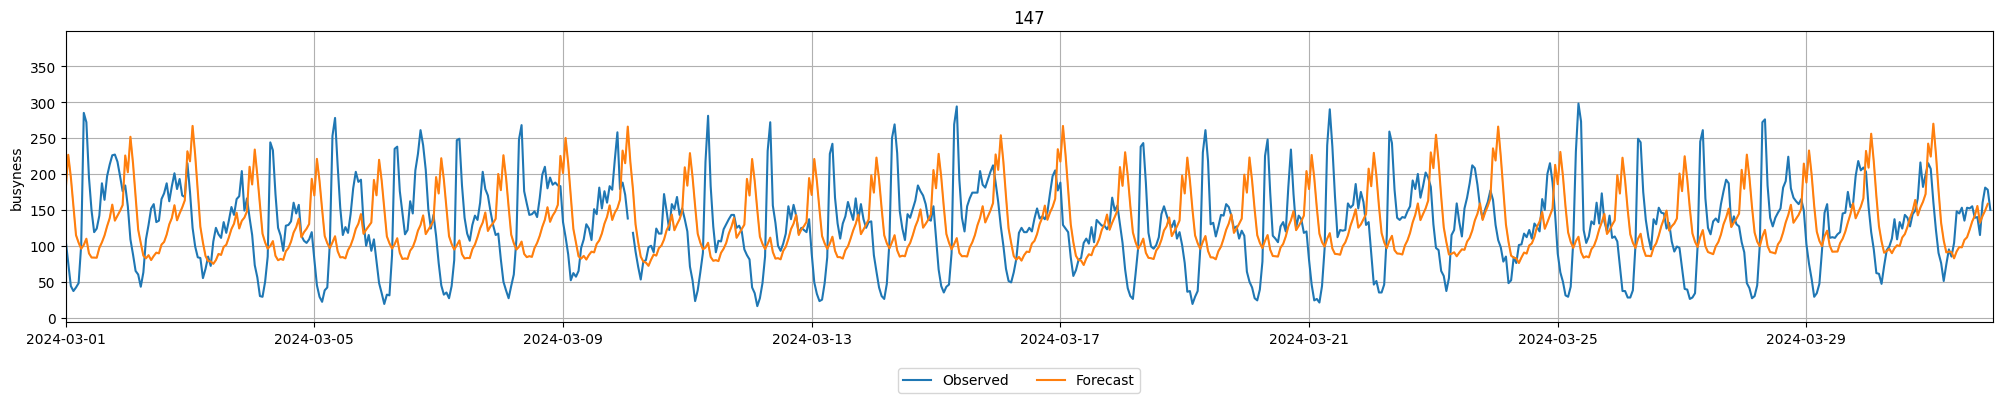

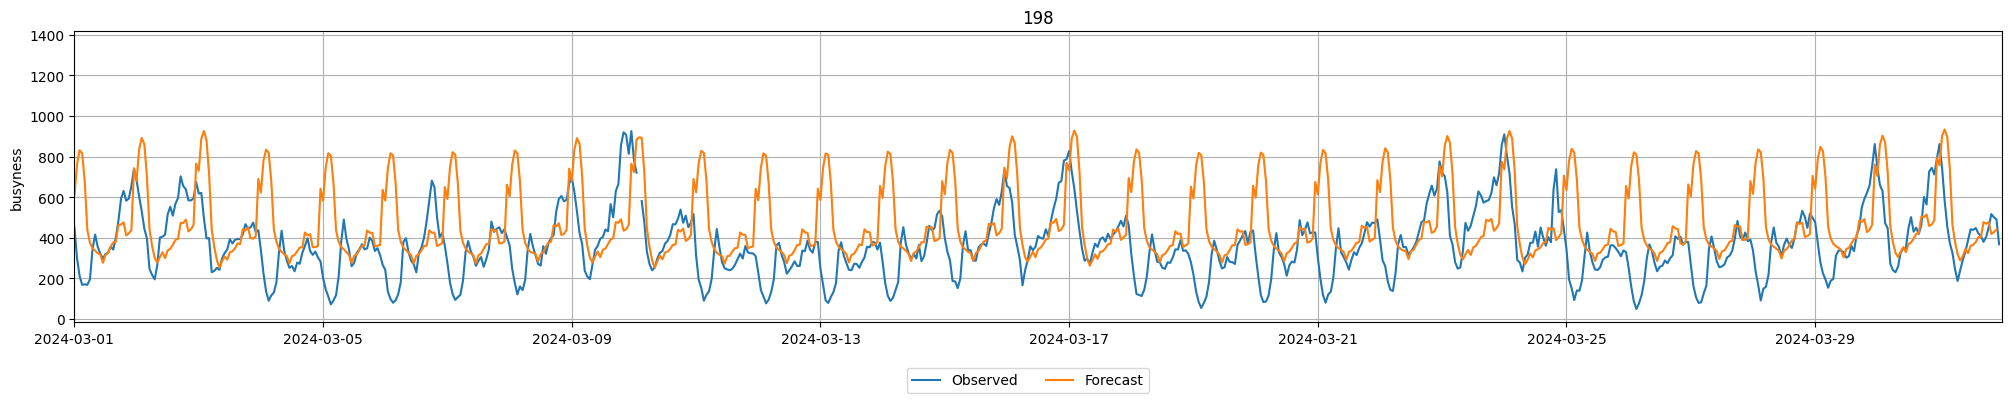

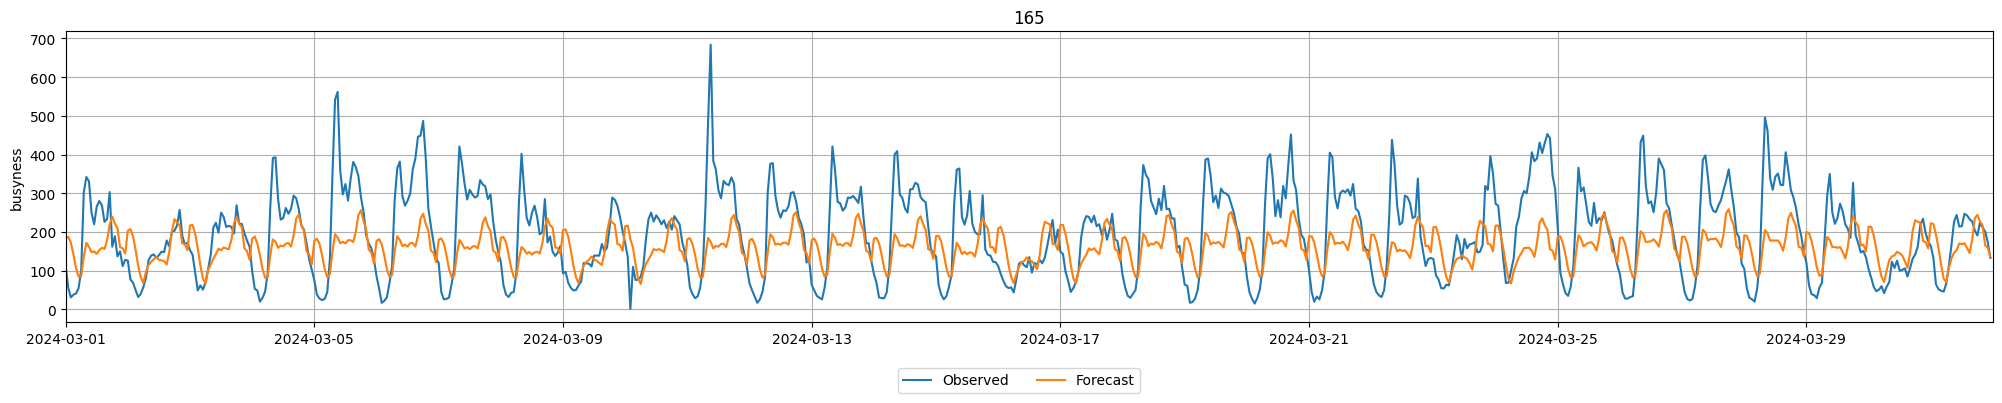

In [13]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [14]:
plt.show()

In [15]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'WAPE': -0.4272270777457013}